## Please first install these libraries
pip install pythreejs pyntcloud pandas numpy

In [1]:
from pyntcloud import PyntCloud
import pandas as pd
import os
import numpy as np
import PIL.Image as Image
%matplotlib inline
from preprocessing import kitti_util
import laspy
# from preprocessing import generate_lidar

In [2]:
def load_velo_scan(velo_filename):
    scan = np.fromfile(velo_filename, dtype=np.float32)
    scan = scan.reshape((-1, 4))
    return scan

In [3]:
def paint_points(points, color=[192,0,0]):
    # color = [r, g, b]
    color = np.array([color])
    new_pts = np.zeros([points.shape[0],6])
    new_pts[:,:3] = points
    new_pts[:, 3:] = new_pts[:, 3:] + color
    return new_pts

def get_original_meshgrid(disp_size, original_size):
    rows, cols = original_size
    c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    crop_rows, crop_cols = disp_size
    left = (cols - crop_cols) // 2
    right = left + crop_cols
    top = rows - crop_rows
    bottom = rows
    h_range = slice(top, bottom)
    w_range = slice(left, right)
    c_cropped = c[h_range, w_range]
    r_cropped = r[h_range, w_range]
    assert c_cropped.shape == disp_size
    return c_cropped, r_cropped

def project_disp_to_points(calib, disp, max_high):
    disp[disp < 0] = 0
    baseline = 0.54
    mask = disp > 0
    depth = calib.f_u * baseline / (disp + 1. - mask)
    # rows, cols = depth.shape
    # c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    original_size = (370, 1226)
    c, r = get_original_meshgrid(depth.shape, original_size)
    points = np.stack([c, r, depth])
    points = points.reshape((3, -1))
    points = points.T
    points = points[mask.reshape(-1)]
    cloud = calib.project_image_to_velo(points)
    valid = (cloud[:, 0] >= 0) & (cloud[:, 2] < max_high)
    return cloud[valid]

def fromNumpy2laspy(lidar, out_path): # the output file should end with ".las"
    header = laspy.header.Header()
    outfile = laspy.file.File(out_path, mode="w", header=header)
    outfile.header.offset = [np.floor(np.min(lidar[:, 0])),\
        np.floor(np.min(lidar[:, 1])),\
        np.floor(np.min(lidar[:, 2]))]
    outfile.header.scale = [0.01,0.01,0.01]  
    outfile.X = lidar[:, 0].flatten()
    outfile.Y = lidar[:, 1].flatten()
    outfile.Z = lidar[:, 2].flatten()
    outfile.Intensity = lidar[:, 3].flatten()
    
    outfile.close()


In [5]:
def generate_point_cloud(disp_np_path, calib_path, output_dir, max_height):
    disp_np_fn = os.path.basename(disp_np_path)
    predix = disp_np_fn[:-4]
    calib = kitti_util.Calibration(calib_path)
    disp_map = np.load(disp_np_path) # [0,1]
    disp_map = (disp_map).astype(np.float32)
    print(disp_map.shape)
    lidar = project_disp_to_points(calib, disp_map, max_height)
    # pad 1 in the indensity dimension
    lidar = np.concatenate([lidar, np.ones((lidar.shape[0], 1))], 1)
    lidar = lidar.astype(np.float32)
    print(lidar.shape)
    out_fn_las = '{}/{}.las'.format(output_dir, predix)
    fromNumpy2laspy(lidar, out_fn_las)
    out_fn = '{}/{}.npy'.format(output_dir, predix)
    # lidar.tofile(out_fn)
    print(lidar.shape)
    np.save(out_fn, lidar)
    return out_fn_las

scene_disp_path1 = "/home/cheng443/projects/Monodepth/Monodepth2_official/DeepPhotoStyle_pytorch/logs/Jun03_18-08-44_trojai/eval_scene_disp.npy"
scene_disp_path2 = "/home/cheng443/projects/Monodepth/Monodepth2_official/DeepPhotoStyle_pytorch/logs/Jun03_18-08-44_trojai/eval_car_scene_disp.npy"
scene_disp_path3 = "/home/cheng443/projects/Monodepth/Monodepth2_official/DeepPhotoStyle_pytorch/logs/Jun03_18-08-44_trojai/eval_adv_scene_disp.npy"
calib_path = "/data/cheng443/kitti/object/training/calib/003086.txt"
output_dir = "/home/cheng443/projects/Monodepth/monodepth2_bob/pseudo_lidar/visualization"
generate_point_cloud(scene_disp_path1, calib_path, output_dir, max_height=2)
generate_point_cloud(scene_disp_path2, calib_path, output_dir, max_height=2)
generate_point_cloud(scene_disp_path3, calib_path, output_dir, max_height=2)


(320, 1024)
(193748, 4)
(193748, 4)
(320, 1024)
(193770, 4)
(193770, 4)
(320, 1024)
(193764, 4)
(193764, 4)


'/home/cheng443/projects/Monodepth/monodepth2_bob/pseudo_lidar/visualization/eval_adv_scene_disp.las'

In [18]:

# path = "/home/cheng443/projects/Monodepth/Monodepth2_official/pseudo_lidar/visualization/000012.bin"

In [26]:

def draw_pointcloud(path):
    points = load_velo_scan(path)[:,:3]
    pd_points = pd.DataFrame(paint_points(points), columns=['x','y','z','red','green','blue'])
    cloud = PyntCloud(pd_points)
    cloud.plot(initial_point_size=0.02)



## The expected interface is shown bellow. If you cannot get it, please reopen your web browser.

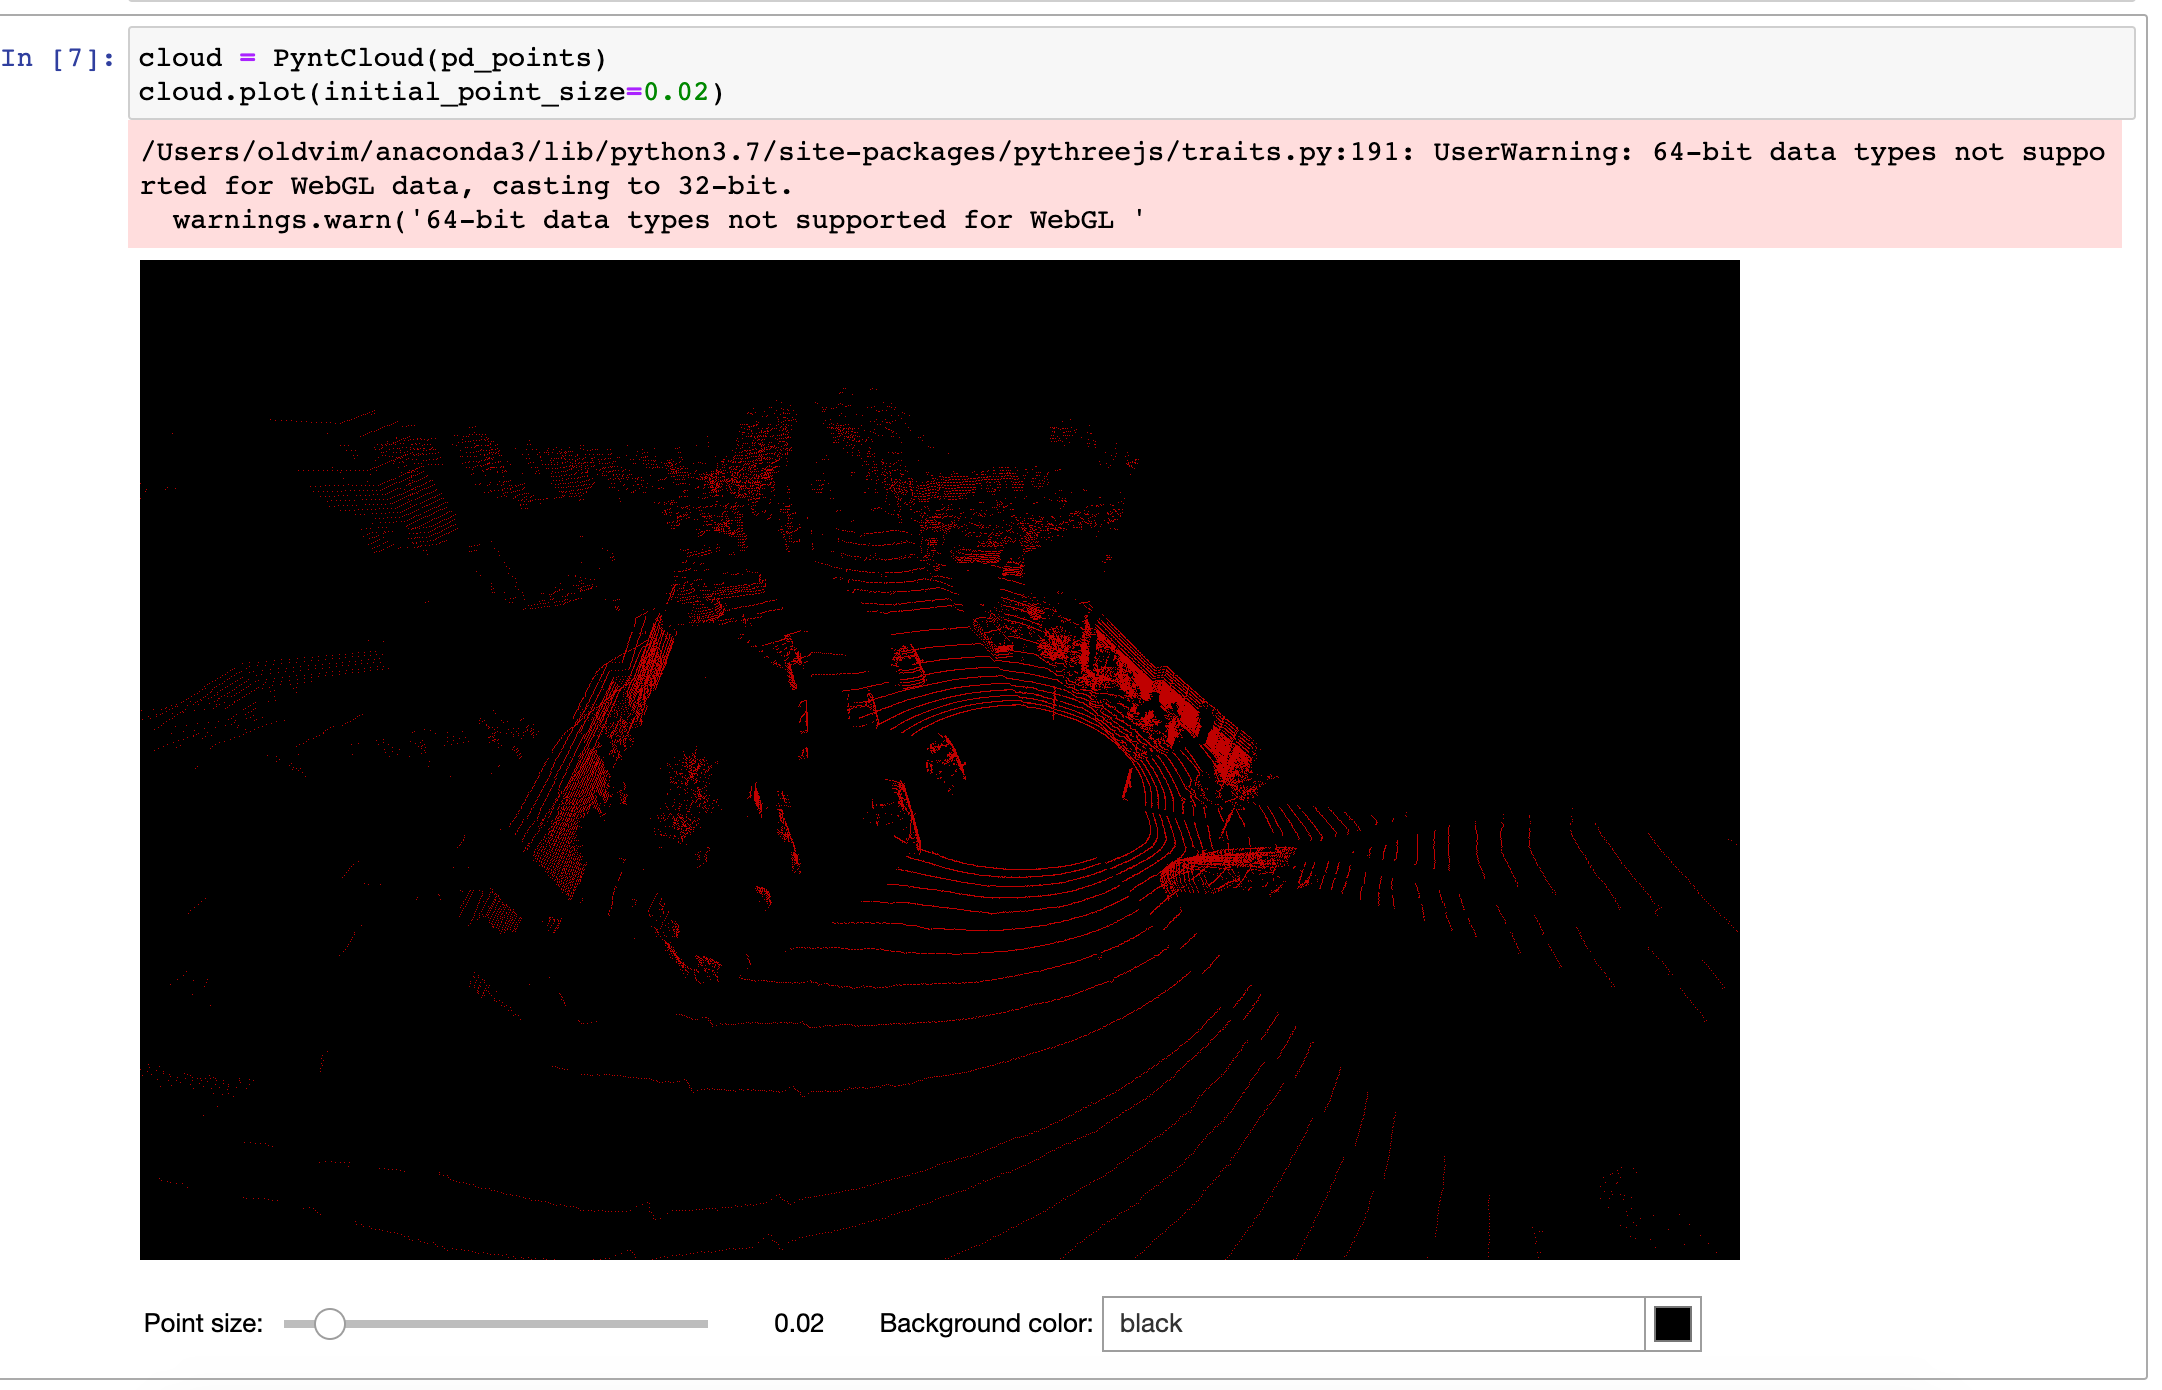

In [9]:
Image.open('./pyntcloud.png')